In [34]:
#import libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#importing GBM-TP dataset
df= pd.read_csv("GBM features.csv")# header=None, skiprows=1)
#df = df.rename(columns=df.iloc[0]).drop(df.index[0])

#dropping last 7 rows
df = df[:-7]

col_list = list()
for col in df.columns:
    col_list.append(col)

CLIs_col_list = col_list[0:13]
CLIs_col_list

CLIs_df = df.filter(CLIs_col_list, axis=1)

#Processed features:
key = ['tcga_participant_barcode']

numerical_CLIs_list = [
    'CLI_years_to_birth', #age
    'CLI_days_to_death',  #changed to Overall_Survival
    'CLI_date_of_initial_pathologic_diagnosis', #seemes useless, unless we want to generalise that "technological advancement prolongs life"?
    'CLI_karnofsky_performance_score' #range from 0 to 100. A higher score means the patient is better able to carry out daily activities.
]

categorical_CLIs_list = [
    'CLI_gender',
    'CLI_radiation_therapy',    #better convert yes/no to 0/1
    'CLI_histological_type',    #3 forms, ['untreated primary (de novo) gbm' 'treated primary gbm', 'glioblastoma multiforme (gbm)']
    'CLI_race',             #4 forms, ['white' 'black or african american' nan 'asian']. 
    'CLI_ethnicity'         #3 forms, [nan 'hispanic or latino' 'not hispanic or latino'].
]

#Modify df according to processed features:
processed_CLIs_df = CLIs_df.filter(key + numerical_CLIs_list + categorical_CLIs_list, axis=1)
processed_CLIs_df = processed_CLIs_df[processed_CLIs_df['CLI_days_to_death'].notnull()]
processed_CLIs_df.rename(columns={'CLI_days_to_death': 'Overall_Survival'}, inplace=True)
processed_CLIs_df

#one-hot encoding
#for columns which null values exist(all columns except gender), drop_first=false since the categories are not collectively exhausive
# -->0 in all categories implies NaN

genderDummy = pd.get_dummies(processed_CLIs_df['CLI_gender'],drop_first=True,prefix='CLI_gender')
radiationDummy = pd.get_dummies(processed_CLIs_df['CLI_radiation_therapy'],drop_first=False,prefix='CLI_radiation_therapy')
histologicalDummy = pd.get_dummies(processed_CLIs_df['CLI_histological_type'],drop_first=False,prefix='CLI_histological_type')
raceDummy = pd.get_dummies(processed_CLIs_df['CLI_race'],drop_first=False,prefix='CLI_race')
ethnicityDummy = pd.get_dummies(processed_CLIs_df['CLI_ethnicity'],drop_first=False,prefix='CLI_ethnicity')

processed_CLIs_df = processed_CLIs_df.drop(columns=['CLI_gender','CLI_radiation_therapy','CLI_histological_type','CLI_race','CLI_ethnicity'])
processed_CLIs_df = pd.concat([processed_CLIs_df,genderDummy,radiationDummy,histologicalDummy,raceDummy,ethnicityDummy],axis=1,sort=True)

#replace NaN by median CLI_karnofsky_performance_score(80)
processed_CLIs_df['CLI_karnofsky_performance_score'].median()

#replace NaN by median CLI_karnofsky_performance_score(80)
processed_CLIs_df['CLI_karnofsky_performance_score'].fillna(processed_CLIs_df['CLI_karnofsky_performance_score'].median(), inplace=True)

# define the datafram for feature and target
X = processed_CLIs_df.drop(['tcga_participant_barcode', 'Overall_Survival'], axis=1)
y = processed_CLIs_df[['Overall_Survival']]


In [35]:
y.describe()

,Overall_Survival
count,490.000000
mean,504.500000
std,538.727567
min,3.000000
25%,170.500000
50%,382.000000
75%,609.250000
max,3881.000000


# NN model


In [36]:
#Linear Regression

from sklearn import preprocessing
#normalize attributes for more even coefficients
zscore_scaler = preprocessing.StandardScaler().fit(X)
X = pd.DataFrame(zscore_scaler.transform(X), columns = X.columns)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =42)

import keras as K
import tensorflow as tf
from keras.layers import Dense, Activation
from keras.models import Sequential
import matplotlib.pyplot as plt

# Feature Scaling
from sklearn.preprocessing import StandardScaler

In [37]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(16, activation = 'relu', input_dim = 14))

# Adding the second hidden layer
model.add(Dense(units = 8, activation = 'relu'))
"""
# Adding the third hidden layer
model.add(Dense(units = 4, activation = 'relu'))
"""

# Adding the output layer

model.add(Dense(units = 1))

#model.add(Dense(1))
# Compiling the ANN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the ANN to the Training set(mini-batched gradient descent)
np.random.seed(0)
tf.random.set_seed(0)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 10, epochs = 200)
"""
y_pred = model.predict(X_test)
plt.plot(y_test, color = 'red', label = 'Real data')
plt.plot(y_pred, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

np.random.seed(0)
tf.random.set_seed(0)
history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_data=(test_feats_matrix, test_label_matrix),
                    epochs=100, batch_size=100, verbose=0)
"""

Epoch 1/200
40/40 [==============================] - 1s 5ms/step - loss: 555058.5625 - val_loss: 502120.6875
Epoch 2/200
40/40 [==============================] - 0s 2ms/step - loss: 554624.0625 - val_loss: 501752.0938
Epoch 3/200
40/40 [==============================] - 0s 2ms/step - loss: 554167.9375 - val_loss: 501288.5625
Epoch 4/200
40/40 [==============================] - 0s 2ms/step - loss: 553513.8125 - val_loss: 500558.8438
Epoch 5/200
40/40 [==============================] - 0s 2ms/step - loss: 552394.5625 - val_loss: 499370.4062
Epoch 6/200
40/40 [==============================] - 0s 2ms/step - loss: 550487.2500 - val_loss: 497178.7500
Epoch 7/200
40/40 [==============================] - 0s 2ms/step - loss: 547199.5000 - val_loss: 493637.3750
Epoch 8/200
40/40 [==============================] - 0s 4ms/step - loss: 541977.7500 - val_loss: 488069.1562
Epoch 9/200
40/40 [==============================] - 0s 2ms/step - loss: 534158.8750 - val_loss: 479909.3125
Epoch 10/200
40/40 

"\ny_pred = model.predict(X_test)\nplt.plot(y_test, color = 'red', label = 'Real data')\nplt.plot(y_pred, color = 'blue', label = 'Predicted data')\nplt.title('Prediction')\nplt.legend()\nplt.show()\n\nnp.random.seed(0)\ntf.random.set_seed(0)\nhistory = model.fit(train_feats_matrix, train_label_matrix,\n                    validation_data=(test_feats_matrix, test_label_matrix),\n                    epochs=100, batch_size=100, verbose=0)\n"

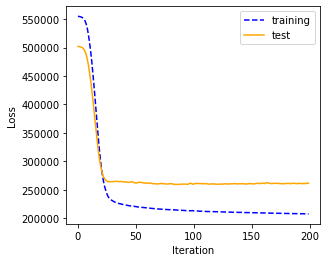

In [38]:
''' Plot loss-iteration '''
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [39]:
from sklearn.metrics import mean_squared_error
train_rms = mean_squared_error(y_train, model.predict(X_train), squared=False)
print(f"train rmse ={train_rms}")

test_rms = mean_squared_error(y_test, model.predict(X_test), squared=False)
print(f"test rmse ={test_rms}")

13/13 [==============================] - 0s 831us/step
train rmse =455.47282790692674
4/4 [==============================] - 0s 2ms/step
test rmse =511.3465687948461


Combining Genomic

In [40]:
#getting genomic features
genomic_df = df.drop(df.columns[range(1, 13)],axis=1,inplace=False)
#fill null by 0
genomic_df_0 = genomic_df.fillna(value=0, inplace = False)
#merge CLI and Genomic
full_X = pd.merge(processed_CLIs_df, genomic_df_0, on='tcga_participant_barcode', how='inner')
full_X.drop(['tcga_participant_barcode', 'Overall_Survival'], axis=1, inplace = True)
#normalization
zscore_scaler = preprocessing.StandardScaler().fit(full_X)
full_X = pd.DataFrame(zscore_scaler.transform(full_X), columns = full_X.columns)
full_X_train, full_X_test, y_train, y_test = train_test_split(full_X, y, test_size=0.2,random_state =42)

In [41]:
#NN
sc = StandardScaler()
full_X_train = sc.fit_transform(full_X_train)
full_X_test = sc.transform(full_X_test)

def build_full_NN(num_input_layer_unit, num_first_layer_unit=17, num_second_layer_unit=8):
    # Initialising the ANN
    full_NN_model = Sequential()

    # Adding the input layer and the first hidden layer
    full_NN_model.add(Dense(num_first_layer_unit, activation = 'relu', input_dim = num_input_layer_unit))

    # Adding the second hidden layer
    full_NN_model.add(Dense(units = num_second_layer_unit, activation = 'relu'))
    """
    # Adding the third hidden layer
    full_NN_model.add(Dense(units = 4, activation = 'relu'))
    """

    # Adding the output layer
    full_NN_model.add(Dense(units = 1))

    # Compiling the ANN
    full_NN_model.compile(optimizer = 'Adam', loss = 'mean_squared_error')

    return full_NN_model

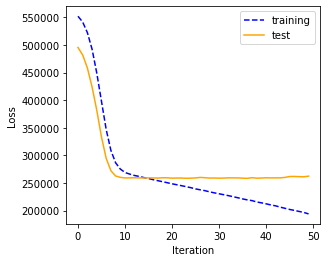

(train rmse, test rmse)=(437.87,512.24)


In [42]:
''' Plot loss-iteration for (9,11) '''
full_NN_model = build_full_NN(662, 9,11)
full_history = full_NN_model.fit(full_X_train, y_train, validation_data=(full_X_test, y_test), batch_size = 10, epochs = 50, verbose = 0)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(full_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(full_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, full_NN_model.predict(full_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, full_NN_model.predict(full_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")

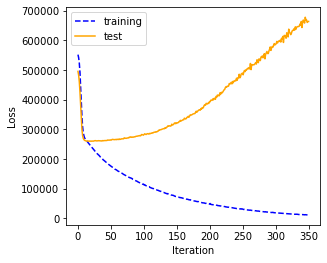

(train rmse, test rmse)=(106.74,814.9)


In [51]:
''' Plot loss-iteration for (9,11) '''
full_NN_model = build_full_NN(662, 9,11)
full_history = full_NN_model.fit(full_X_train, y_train, validation_data=(full_X_test, y_test), batch_size = 10, epochs = 350, verbose = 0)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(full_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(full_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, full_NN_model.predict(full_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, full_NN_model.predict(full_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")

In [52]:
#check if optimal epochs attained
for i in range(1, 8):
    full_NN_model = build_full_NN(662, 9,11)
    full_history = full_NN_model.fit(full_X_train, y_train, validation_data=(full_X_test, y_test), batch_size = 10, epochs = i*50, verbose = 0)
    '''
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(full_history.history["loss"], label="training", color="blue", linestyle="dashed")
    plt.plot(full_history.history["val_loss"], label="test", color="orange")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    '''
    train_rms = mean_squared_error(y_train, full_NN_model.predict(full_X_train, verbose=0), squared=False)
    test_rms = mean_squared_error(y_test, full_NN_model.predict(full_X_test, verbose=0), squared=False)
    print(f"(epochs, train rmse, test rmse)=({i*50},{round(train_rms, 2)},{round(test_rms, 2)})")

(epochs, train rmse, test rmse)=(50,427.55,514.97)
(epochs, train rmse, test rmse)=(100,319.79,555.2)
(epochs, train rmse, test rmse)=(150,262.65,571.53)
(epochs, train rmse, test rmse)=(200,239.62,614.02)
(epochs, train rmse, test rmse)=(250,190.4,634.77)
(epochs, train rmse, test rmse)=(300,151.09,750.74)
(epochs, train rmse, test rmse)=(350,92.31,946.12)



1.try genomic NN model again with only Lasso selected features

2.CNN conbolution on mutation pairs

3.NN hyper param, layers

4.PCA, SVD, and matrix factorization


Goal:
RMSE < 456

In [53]:
#get Lasso selected features
CLI_lasso_selected = ["CLI_years_to_birth",
"CLI_date_of_initial_pathologic_diagnosis",
"CLI_karnofsky_performance_score",
"CLI_gender_male",
"CLI_radiation_therapy_no",
"CLI_radiation_therapy_yes",
"CLI_histological_type_treated primary gbm",
"CLI_ethnicity_hispanic or latino",
"CLI_ethnicity_not hispanic or latino"
]
full_lasso_selected = ["CLI_years_to_birth",
"CLI_date_of_initial_pathologic_diagnosis",
"CLI_karnofsky_performance_score",
"CLI_radiation_therapy_no",
"CLI_radiation_therapy_yes",
"CLI_histological_type_treated primary gbm",
"SMG_mutsig2.0_SFT2D1_cosmic",
"Amp_8q24.21 ",
"Del_1p36.32 ",
"Del_10p11.23",
"CN_1p_Amp"]


full_X_lasso_selected = full_X.loc[:, list(set(CLI_lasso_selected).union(set(full_lasso_selected)))] #get from both lists
full_lasso_selected_X_train, full_lasso_selected_X_test, y_train, y_test = train_test_split(full_X_lasso_selected, y, test_size=0.2,random_state =42)
full_lasso_selected_X_train = sc.fit_transform(full_lasso_selected_X_train)
full_lasso_selected_X_test = sc.transform(full_lasso_selected_X_test)

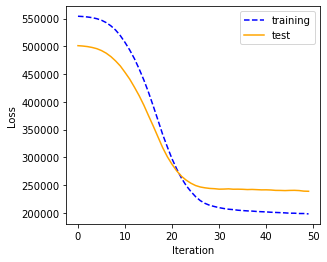

(train rmse, test rmse)=(444.31,488.56)


In [54]:
''' Plot loss-iteration for (9,11) '''
full_lasso_selected_NN_model = build_full_NN(14,9,11)
full_lasso_selected_history = full_lasso_selected_NN_model.fit(full_lasso_selected_X_train, y_train, validation_data=(full_lasso_selected_X_test, y_test), batch_size = 10, epochs = 50, verbose = 0)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(full_lasso_selected_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(full_lasso_selected_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, full_lasso_selected_NN_model.predict(full_lasso_selected_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, full_lasso_selected_NN_model.predict(full_lasso_selected_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")

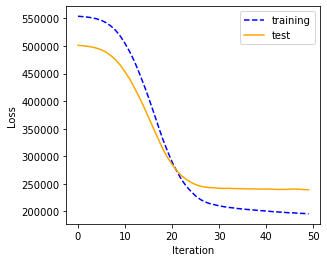

(epochs, train rmse, test rmse)=(50,441.3,489.14)


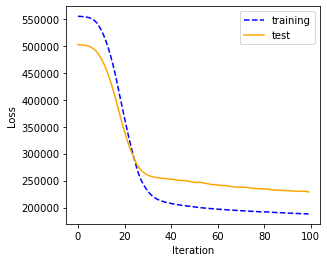

(epochs, train rmse, test rmse)=(100,433.13,478.41)


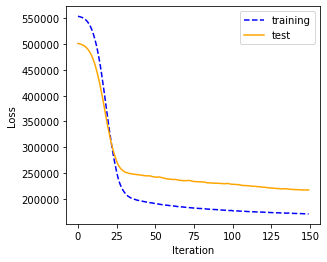

(epochs, train rmse, test rmse)=(150,412.99,466.05)


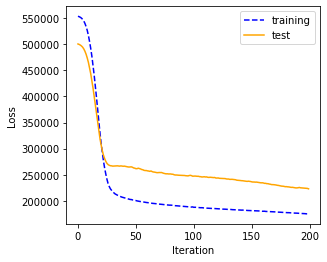

(epochs, train rmse, test rmse)=(200,417.98,472.33)


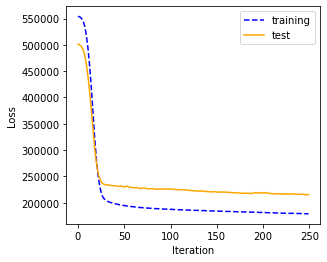

(epochs, train rmse, test rmse)=(250,422.35,464.39)


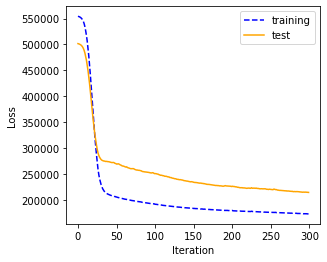

(epochs, train rmse, test rmse)=(300,415.02,462.74)


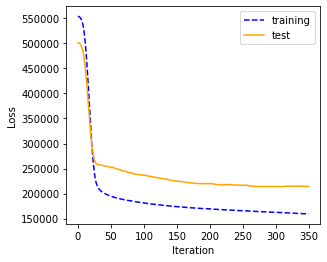

(epochs, train rmse, test rmse)=(350,398.89,463.0)


In [55]:
for i in range(1, 8):
    full_lasso_selected_NN_model = build_full_NN(14,9,11)
    full_lasso_selected_history = full_lasso_selected_NN_model.fit(full_lasso_selected_X_train, y_train, validation_data=(full_lasso_selected_X_test, y_test), batch_size = 10, epochs = i*50, verbose = 0)
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(full_lasso_selected_history.history["loss"], label="training", color="blue", linestyle="dashed")
    plt.plot(full_lasso_selected_history.history["val_loss"], label="test", color="orange")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()
    train_rms = mean_squared_error(y_train, full_lasso_selected_NN_model.predict(full_lasso_selected_X_train, verbose=0), squared=False)
    test_rms = mean_squared_error(y_test, full_lasso_selected_NN_model.predict(full_lasso_selected_X_test, verbose=0), squared=False)
    print(f"(epochs, train rmse, test rmse)=({i*50},{round(train_rms, 2)},{round(test_rms, 2)})")

optimal epoch for lasso-selected features are much higher, settled at around 300 and give test rmse of 462.74

now check if optimal layer nodes for lasso-selected features differs from (9, 11)  

In [56]:
#try different number of units in each hidden layer
num_hidden_unit= list()
for  x in range(8, 34,2):
    for y in range(4, 26,2):
        num_hidden_unit.append((x,y))

rmse_for_each_num_hidden = list()
for a, b in num_hidden_unit:
    full_lasso_selected_NN_model = build_full_NN(14,a,b)
    full_lasso_selected_history = full_lasso_selected_NN_model.fit(full_lasso_selected_X_train, y_train, validation_data=(full_lasso_selected_X_test, y_test), batch_size = 10, epochs = 150, verbose = 0)
    train_rms = mean_squared_error(y_train, full_lasso_selected_NN_model.predict(full_lasso_selected_X_train, verbose=0), squared=False)
    test_rms = mean_squared_error(y_test, full_lasso_selected_NN_model.predict(full_lasso_selected_X_test, verbose=0), squared=False)

    print(f"(first_layer, second_layer, train rmse, test rmse)=({a},{b},{round(train_rms, 2)},{round(test_rms, 2)})")
    rmse_for_each_num_hidden.append((a,b,train_rms,test_rms))



(first_layer, second_layer, train rmse, test rmse)=(8,4,431.41,476.31)
(first_layer, second_layer, train rmse, test rmse)=(8,6,423.93,466.25)
(first_layer, second_layer, train rmse, test rmse)=(8,8,430.28,483.38)
(first_layer, second_layer, train rmse, test rmse)=(8,10,417.01,476.45)
(first_layer, second_layer, train rmse, test rmse)=(8,12,410.86,468.23)
(first_layer, second_layer, train rmse, test rmse)=(8,14,424.29,471.66)
(first_layer, second_layer, train rmse, test rmse)=(8,16,426.52,481.09)
(first_layer, second_layer, train rmse, test rmse)=(8,18,423.33,466.3)
(first_layer, second_layer, train rmse, test rmse)=(8,20,409.5,473.74)
(first_layer, second_layer, train rmse, test rmse)=(8,22,410.21,457.8)
(first_layer, second_layer, train rmse, test rmse)=(8,24,424.06,473.72)
(first_layer, second_layer, train rmse, test rmse)=(10,4,422.32,479.55)
(first_layer, second_layer, train rmse, test rmse)=(10,6,439.85,512.82)
(first_layer, second_layer, train rmse, test rmse)=(10,8,418.65,465.75

In [57]:
min(rmse_for_each_num_hidden, key = lambda t: t[3])

(30, 20, 405.83120307295354, 448.9120919965287)

In [58]:
#convert list to dict
rmse_dict = dict()
for first_layer, second_layer, train_rmse, test_rmse in rmse_for_each_num_hidden:
    rmse_dict[(first_layer, second_layer)] = test_rmse

Text(0, 0.5, 'second_layer_nodes')

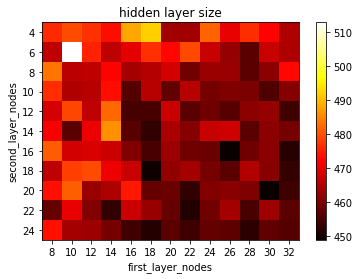

In [73]:
plt.figure(figsize=(6, 4))
# you should have a dictionary here.
a3 = np.array([[rmse_dict[(first_layer, second_layer)] for first_layer in range(8, 34,2)] for second_layer in range(4, 26,2)])
plt.title('hidden layer size')
plt.imshow(a3, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=range(0, 13), labels=range(8, 34,2))
plt.xlabel("first_layer_nodes")
plt.yticks(ticks=range(0, 11), labels=range(4, 26,2))
plt.ylabel("second_layer_nodes")


rmse is optimized at (30, 20), followed by (26, 16) and (18, 18)
now try push to 350 epochs for this.

In [81]:
for i in range(1, 8):
    full_lasso_selected_NN_model = build_full_NN(14, 30, 20)
    full_lasso_selected_history = full_lasso_selected_NN_model.fit(full_lasso_selected_X_train, y_train, validation_data=(full_lasso_selected_X_test, y_test), batch_size = 10, epochs = i*50, verbose = 0)
    '''
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(full_lasso_selected_history.history["loss"], label="training", color="blue", linestyle="dashed")
    plt.plot(full_lasso_selected_history.history["val_loss"], label="test", color="orange")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    '''
    train_rms = mean_squared_error(y_train, full_lasso_selected_NN_model.predict(full_lasso_selected_X_train, verbose=0), squared=False)
    test_rms = mean_squared_error(y_test, full_lasso_selected_NN_model.predict(full_lasso_selected_X_test, verbose=0), squared=False)
    print(f"(epochs, train rmse, test rmse)=({i*50},{round(train_rms, 2)},{round(test_rms, 2)})")

(epochs, train rmse, test rmse)=(50,428.47,476.45)
(epochs, train rmse, test rmse)=(100,407.22,456.13)
(epochs, train rmse, test rmse)=(150,399.74,454.4)
(epochs, train rmse, test rmse)=(200,392.06,463.02)
(epochs, train rmse, test rmse)=(250,386.92,455.02)
(epochs, train rmse, test rmse)=(300,383.65,447.98)
(epochs, train rmse, test rmse)=(350,378.18,464.01)


In [87]:
for i in range(1, 8):
    full_lasso_selected_NN_model = build_full_NN(14, 30, 20)
    full_lasso_selected_history = full_lasso_selected_NN_model.fit(full_lasso_selected_X_train, y_train, validation_data=(full_lasso_selected_X_test, y_test), batch_size = 10, epochs = 60+i*20, verbose = 0)
    '''
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(full_lasso_selected_history.history["loss"], label="training", color="blue", linestyle="dashed")
    plt.plot(full_lasso_selected_history.history["val_loss"], label="test", color="orange")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    '''
    train_rms = mean_squared_error(y_train, full_lasso_selected_NN_model.predict(full_lasso_selected_X_train, verbose=0), squared=False)
    test_rms = mean_squared_error(y_test, full_lasso_selected_NN_model.predict(full_lasso_selected_X_test, verbose=0), squared=False)
    print(f"(epochs, train rmse, test rmse)=({60+i*20},{round(train_rms, 2)},{round(test_rms, 2)})")

(epochs, train rmse, test rmse)=(80,413.38,459.9)
(epochs, train rmse, test rmse)=(100,407.57,462.18)
(epochs, train rmse, test rmse)=(120,407.24,460.25)
(epochs, train rmse, test rmse)=(140,403.46,455.85)
(epochs, train rmse, test rmse)=(160,403.29,449.9)
(epochs, train rmse, test rmse)=(180,398.14,450.8)
(epochs, train rmse, test rmse)=(200,394.58,453.99)


(30, 20): epoch optimized at ~160


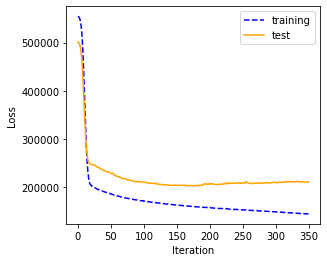

(epochs, train rmse, test rmse)=(350,379.15,458.91)


In [82]:
full_lasso_selected_NN_model = build_full_NN(14, 30, 20)
full_lasso_selected_history = full_lasso_selected_NN_model.fit(full_lasso_selected_X_train, y_train, validation_data=(full_lasso_selected_X_test, y_test), batch_size = 10, epochs = 350, verbose = 0)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(full_lasso_selected_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(full_lasso_selected_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()
train_rms = mean_squared_error(y_train, full_lasso_selected_NN_model.predict(full_lasso_selected_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, full_lasso_selected_NN_model.predict(full_lasso_selected_X_test, verbose=0), squared=False)
print(f"(epochs, train rmse, test rmse)=({350},{round(train_rms, 2)},{round(test_rms, 2)})")

In [88]:
#18, 18
for i in range(1, 8):
    full_lasso_selected_NN_model = build_full_NN(14, 18, 18)
    full_lasso_selected_history = full_lasso_selected_NN_model.fit(full_lasso_selected_X_train, y_train, validation_data=(full_lasso_selected_X_test, y_test), batch_size = 10, epochs = i*50, verbose = 0)
    '''
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(full_lasso_selected_history.history["loss"], label="training", color="blue", linestyle="dashed")
    plt.plot(full_lasso_selected_history.history["val_loss"], label="test", color="orange")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    '''
    train_rms = mean_squared_error(y_train, full_lasso_selected_NN_model.predict(full_lasso_selected_X_train, verbose=0), squared=False)
    test_rms = mean_squared_error(y_test, full_lasso_selected_NN_model.predict(full_lasso_selected_X_test, verbose=0), squared=False)
    print(f"(epochs, train rmse, test rmse)=({i*50},{round(train_rms, 2)},{round(test_rms, 2)})")

(epochs, train rmse, test rmse)=(50,441.4,489.82)
(epochs, train rmse, test rmse)=(100,421.87,478.15)
(epochs, train rmse, test rmse)=(150,404.76,457.79)
(epochs, train rmse, test rmse)=(200,401.11,459.83)
(epochs, train rmse, test rmse)=(250,395.93,461.24)
(epochs, train rmse, test rmse)=(300,391.21,448.94)
(epochs, train rmse, test rmse)=(350,392.21,456.9)


In [89]:
#26, 16
for i in range(1, 8):
    full_lasso_selected_NN_model = build_full_NN(14, 26, 16)
    full_lasso_selected_history = full_lasso_selected_NN_model.fit(full_lasso_selected_X_train, y_train, validation_data=(full_lasso_selected_X_test, y_test), batch_size = 10, epochs = i*50, verbose = 0)
    '''
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(full_lasso_selected_history.history["loss"], label="training", color="blue", linestyle="dashed")
    plt.plot(full_lasso_selected_history.history["val_loss"], label="test", color="orange")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    '''
    train_rms = mean_squared_error(y_train, full_lasso_selected_NN_model.predict(full_lasso_selected_X_train, verbose=0), squared=False)
    test_rms = mean_squared_error(y_test, full_lasso_selected_NN_model.predict(full_lasso_selected_X_test, verbose=0), squared=False)
    print(f"(epochs, train rmse, test rmse)=({i*50},{round(train_rms, 2)},{round(test_rms, 2)})")

(epochs, train rmse, test rmse)=(50,431.05,488.92)
(epochs, train rmse, test rmse)=(100,409.87,466.44)
(epochs, train rmse, test rmse)=(150,413.88,459.7)
(epochs, train rmse, test rmse)=(200,397.91,465.32)
(epochs, train rmse, test rmse)=(250,392.16,462.9)
(epochs, train rmse, test rmse)=(300,388.72,459.96)
(epochs, train rmse, test rmse)=(350,386.77,458.16)


tested up to 350 epochs, (26, 16) and (18, 18) are not as good as (30, 20).